
### Subgroup Analysis Notebook

1. **subgroup_analysis.ipynb**:  
   In this notebook, you can:
   - Load test predictions (if you modify inference to save predictions to a CSV or pickle).
   - Filter predictions by subgroup criteria (e.g., age < 40).
   - Compute metrics (AUROC, F1, etc.) on these filtered sets.
   - Generate plots comparing subgroups.


In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)




# === CONFIGURATION ===

In [14]:
predictions_path = "/teamspace/studios/this_studio/test_predictions.csv"
labels_path = "/teamspace/studios/this_studio/src/data/nih_chest_xray/labels.csv"

disease_names = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# === FUNCTIONS ===

In [15]:

def get_performance_metrics(df, disease_names, subgroup_col=None, subgroup_value=None):
    """
    Compute AUROC, F1, Precision, and Recall for each disease in disease_names.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing columns true_<disease> and pred_<disease>
        disease_names (list): List of disease strings
        subgroup_col (str, optional): Column to filter by (e.g., "Patient Gender")
        subgroup_value (str or other): Value to filter subgroup_col by (e.g., "M")
    
    Returns:
        pd.DataFrame: Index = diseases, columns = AUROC, F1, Precision, Recall
    """
    subset = df
    if subgroup_col is not None and subgroup_value is not None:
        subset = df[df[subgroup_col] == subgroup_value]

    metrics = {}
    for disease in disease_names:
        y_true = subset[f'true_{disease}']
        y_pred = subset[f'pred_{disease}']
        if y_true.sum() == 0:
            # No positives, assign NaN
            metrics[disease] = {'AUROC': np.nan, 'F1': np.nan, 'Precision': np.nan, 'Recall': np.nan}
        else:
            auroc = roc_auc_score(y_true, y_pred)
            f1 = f1_score(y_true, (y_pred>0.5), zero_division=0)
            prec = precision_score(y_true, (y_pred>0.5), zero_division=0)
            rec = recall_score(y_true, (y_pred>0.5), zero_division=0)
            metrics[disease] = {'AUROC': auroc, 'F1': f1, 'Precision': prec, 'Recall': rec}
    return pd.DataFrame(metrics).T

def plot_auroc_by_subgroup(df, group_col, diseases, title):
    """
    Create a grouped bar chart of AUROC by disease for each category in group_col.
    """
    groups = df[group_col].dropna().unique()
    aucs_by_group = {}

    # Compute AUROC per group
    for group in groups:
        group_df = df[df[group_col] == group]
        aucs = []
        for disease in diseases:
            if group_df[f'true_{disease}'].sum() > 0:
                auc = roc_auc_score(group_df[f'true_{disease}'], group_df[f'pred_{disease}'])
            else:
                auc = np.nan
            aucs.append(auc)
        aucs_by_group[group] = aucs

    fig, ax = plt.subplots(figsize=(15,6))
    x = np.arange(len(diseases))
    width = 0.8 / len(aucs_by_group)

    for i, (group, scores) in enumerate(aucs_by_group.items()):
        ax.bar(x + i*width - width*len(aucs_by_group)/2, scores, width, label=group)

    ax.set_xticks(x)
    ax.set_xticklabels(diseases, rotation=45, ha='right')
    ax.set_ylabel('AUROC')
    ax.set_title(f'AUROC by Disease and {title}')
    ax.legend()
    plt.tight_layout()
    return fig


# === LOAD DATA ===

In [7]:

preds_df = pd.read_csv(predictions_path)
labels_df = pd.read_csv(labels_path)
labels_df["filename"] = labels_df["image_file_path"].apply(lambda x: x.split("/")[-1])

merged_df = pd.merge(preds_df, labels_df, on="filename", how="left")
if merged_df["Patient Age"].dtype == object:
    merged_df["Patient Age"] = merged_df["Patient Age"].str.replace("Y","").astype(int)

# Create Age Groups
merged_df["age_group"] = pd.cut(
    merged_df["Patient Age"],
    bins=[0,40,60,120],
    labels=["young","middle_aged","old"]
)


# === ANALYSIS ===

Overall AUROC by Disease:
Cardiomegaly          0.888643
Consolidation         0.877893
Hernia                0.874102
Pleural_Thickening    0.835959
Effusion              0.829620
Infiltration          0.825446
Edema                 0.822475
Nodule                0.802772
Atelectasis           0.769372
Mass                  0.759847
Emphysema             0.748783
Pneumonia             0.738707
Fibrosis              0.717941
Pneumothorax          0.690400
Name: AUROC, dtype: float64

AUROC Gender Gaps (Male - Female):
Nodule                0.086378
Infiltration          0.028267
Atelectasis           0.023236
Fibrosis              0.018593
Pneumothorax          0.004207
Consolidation         0.002518
Edema                -0.005028
Mass                 -0.012243
Pneumonia            -0.013672
Cardiomegaly         -0.018369
Pleural_Thickening   -0.022018
Emphysema            -0.024181
Hernia               -0.025189
Effusion             -0.034411
Name: AUROC, dtype: float64

YOUNG AUROCs:

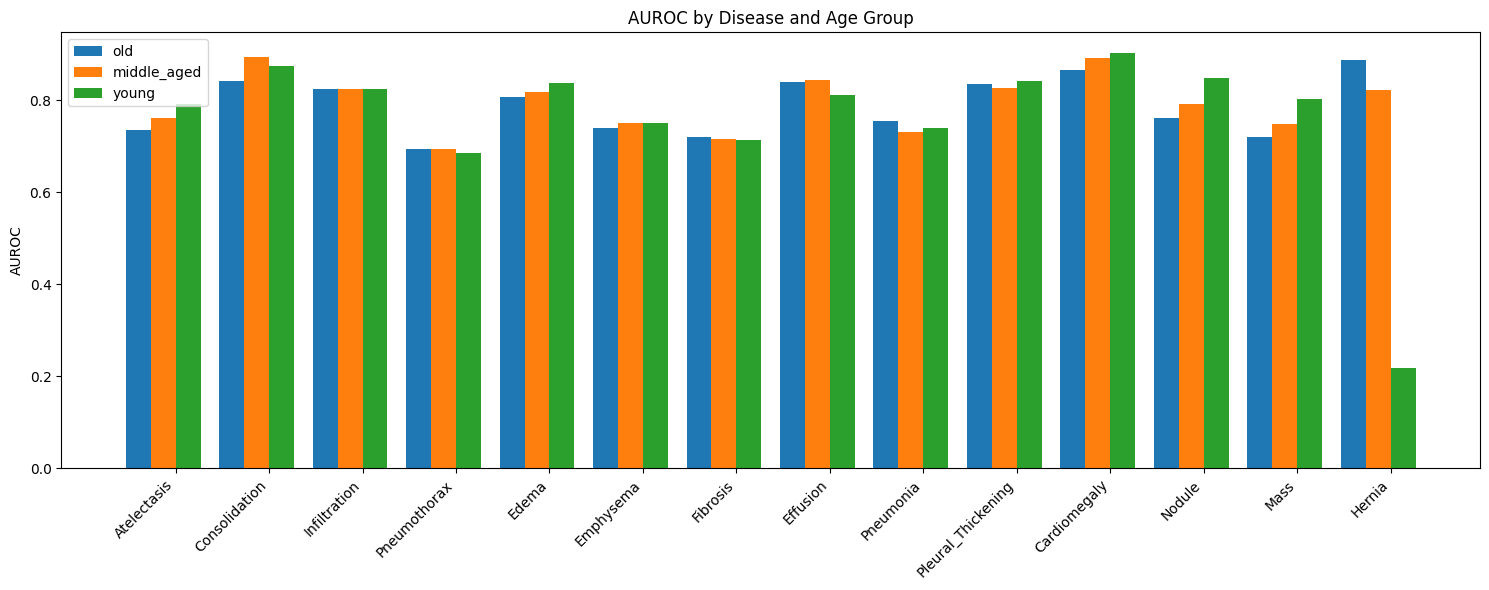

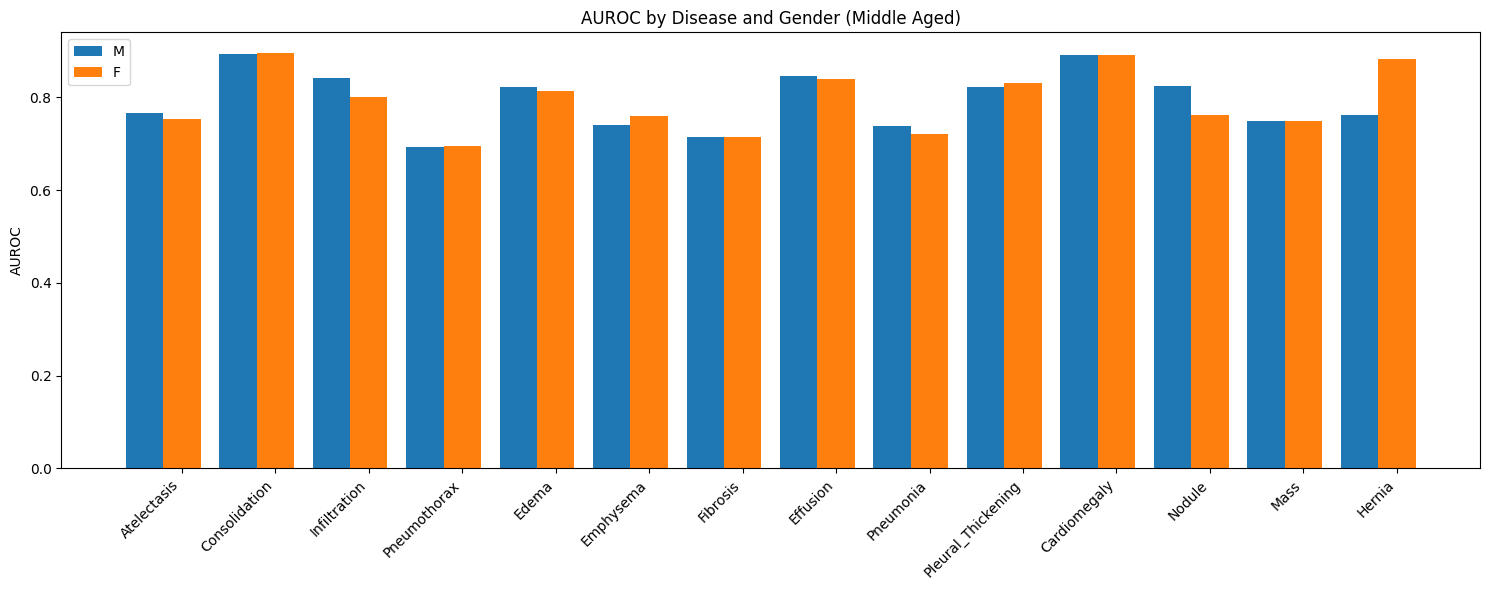

In [17]:

# Overall performance
overall_metrics = get_performance_metrics(merged_df, disease_names)
print("Overall AUROC by Disease:")
print(overall_metrics['AUROC'].sort_values(ascending=False))

# Gender differences (middle-aged example)
male_metrics = get_performance_metrics(merged_df, disease_names, 'Patient Gender', 'M')
female_metrics = get_performance_metrics(merged_df, disease_names, 'Patient Gender', 'F')
gender_gaps = male_metrics['AUROC'] - female_metrics['AUROC']
print("\nAUROC Gender Gaps (Male - Female):")
print(gender_gaps.sort_values(ascending=False))

# By age group example
for age_group in ['young','middle_aged','old']:
    print(f"\n{age_group.upper()} AUROCs:")
    age_metrics = get_performance_metrics(merged_df, disease_names, 'age_group', age_group)
    print(age_metrics['AUROC'].sort_values(ascending=False))

# By view position
pa_metrics = get_performance_metrics(merged_df, disease_names, 'View Position', 'PA')
ap_metrics = get_performance_metrics(merged_df, disease_names, 'View Position', 'AP')
view_gaps = pa_metrics['AUROC'] - ap_metrics['AUROC']
print("\nAUROC View Position Gaps (PA - AP):")
print(view_gaps.sort_values(ascending=False))

# Sample sizes
print("\nSample Sizes by Subgroup:")
print("Gender:\n", merged_df['Patient Gender'].value_counts())
print("Age Group:\n", merged_df['age_group'].value_counts())
print("View Position:\n", merged_df['View Position'].value_counts())

# Plotting
age_fig = plot_auroc_by_subgroup(merged_df, 'age_group', disease_names, 'Age Group')
gender_fig = plot_auroc_by_subgroup(merged_df[merged_df['age_group']=='middle_aged'], 'Patient Gender', disease_names, 'Gender (Middle Aged)')
plt.show()



## Summary of Traditional Model Results

**Overall Performance:**
- High-performing diseases (AUROC > 0.85):  
  - Cardiomegaly (~0.89), Consolidation (~0.88), Hernia (~0.87)
- Moderately challenging diseases (AUROC ~0.75 - 0.80):  
  - Effusion, Pleural_Thickening, Edema, Nodule
- Low-performing diseases (AUROC < 0.75):  
  - Pneumothorax (~0.69), Fibrosis (~0.72), Pneumonia (~0.74), Emphysema (~0.75)

**Subgroup Differences:**
- **Gender:**  
  - Generally small AUROC gaps, but notable advantages:
    - Nodule: +0.086 for males
    - Effusion: ~+0.034 for females (negative gap for males)
- **Age Groups:**  
  - Middle-aged patients often yield stronger metrics (Consolidation ~0.89).
  - Young patients excel at Cardiomegaly (0.90) but struggle with Hernia (0.22).
  - Older patients show more consistent but not always top performance.
- **View Position (PA vs. AP):**  
  - PA views significantly improve Hernia detection (+0.15).
  - AP vs. PA differences vary by disease, highlighting view-dependent performance.

**Sample Sizes:**
- Gender: M ~14.9k, F ~10.7k
- Age Groups: Middle-aged ~11.2k, Young ~8.9k, Old ~5.4k
- View Positions: AP ~14.5k, PA ~11.1k

**Implications:**
These insights form a robust baseline. They show where the traditional model excels and where it struggles, especially in certain subgroups or diseases. This comprehensive baseline sets the stage for evaluating the foundation model, where we anticipate improvements in handling rare conditions, reducing demographic biases, and performing robustly across different acquisition protocols (view positions).

By focusing on these identified gaps, the upcoming comparison with a foundation model will more clearly reveal if and how it addresses these limitations. I will replicate the same pipeline for the foundation model and compare them side by side.

Further statistical significance analysis can be performed with `compare_subgroups()`

Patient Gender
M    14882
F    10714
Name: count, dtype: int64
View Position
AP    14500
PA    11096
Name: count, dtype: int64


<Axes: >

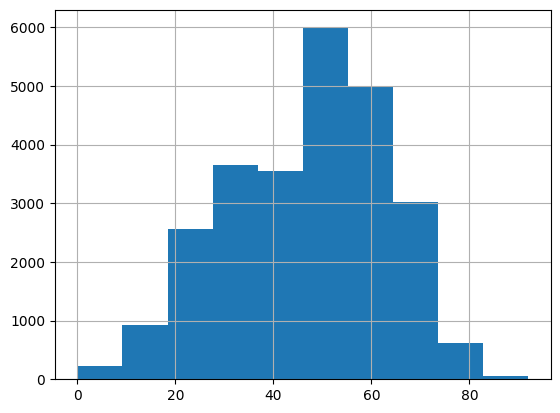

In [10]:

print(merged_df["Patient Gender"].value_counts())
print(merged_df["View Position"].value_counts())
merged_df["Patient Age"].hist()


In [12]:
# saving for later
from sklearn.utils import resample
from scipy import stats

def bootstrap_ci(y_true, y_pred, n_boot=1000, metric=roc_auc_score, alpha=0.05):
    """
    Compute a bootstrap confidence interval for a given metric (default: AUROC).

    Parameters:
        y_true (array-like): Ground truth binary labels (0/1).
        y_pred (array-like): Predicted scores or probabilities.
        n_boot (int): Number of bootstrap iterations (default 1000).
        metric (callable): A metric function that takes (y_true, y_pred) and returns a float.
                           By default, roc_auc_score is used.
        alpha (float): Significance level for the confidence interval (0.05 = 95% CI).

    Returns:
        tuple:
            mean_metric (float): Mean metric value across bootstrap samples.
            (lower_bound, upper_bound) (tuple of floats): 95% confidence interval bounds.
    """
    scores = []
    data = list(zip(y_true, y_pred))
    for _ in range(n_boot):
        sample = resample(data)
        y_samp, p_samp = zip(*sample)
        scores.append(metric(y_samp, p_samp))
    lower = np.percentile(scores, 100*alpha/2)
    upper = np.percentile(scores, 100*(1-alpha/2))
    return np.mean(scores), (lower, upper)

def compare_subgroups(df, subgroup_col, disease):
    """
    Compare AUROCs between two subgroups for a given disease using bootstrap sampling
    to estimate the confidence interval of their difference.

    Parameters:
        df (pd.DataFrame): DataFrame containing predicted probabilities and ground truths.
                           Must include 'true_<disease>' and 'pred_<disease>' columns for the disease,
                           and a column specified by subgroup_col indicating subgroup membership.
                           Assumes exactly two unique subgroup values.
        subgroup_col (str): Column name representing the subgroup variable (e.g., 'Patient Gender').
        disease (str): Name of the disease to evaluate (must match keys in df: true_<disease>, pred_<disease>).

    Returns:
        dict: A dictionary containing:
            'groups' (ndarray): The two subgroup values.
            'aucs' (list[float]): AUROCs for each subgroup.
            'auc_diff' (float): Difference in AUROC (group[0] - group[1]).
            'ci_lower' (float): Lower bound of the 95% bootstrap confidence interval of the difference.
            'ci_upper' (float): Upper bound of the 95% bootstrap confidence interval of the difference.
            'significant' (bool): Whether the CI excludes zero, suggesting a significant difference.
    """
  

    groups = df[subgroup_col].unique()
    
    aucs = []
    for group in groups:
        group_df = df[df[subgroup_col] == group]
        auc = roc_auc_score(
            group_df[f'true_{disease}'],
            group_df[f'pred_{disease}']
        )
        aucs.append(auc)
    
    # Bootstrap test for AUC difference
    n_bootstrap = 1000
    bootstrap_diffs = []
    
    for _ in range(n_bootstrap):
        bootstrap_aucs = []
        for group in groups:
            group_df = df[df[subgroup_col] == group]
            boot_idx = np.random.choice(len(group_df), len(group_df))
            boot_df = group_df.iloc[boot_idx]
            boot_auc = roc_auc_score(
                boot_df[f'true_{disease}'],
                boot_df[f'pred_{disease}']
            )
            bootstrap_aucs.append(boot_auc)
        bootstrap_diffs.append(bootstrap_aucs[0] - bootstrap_aucs[1])
    
    ci_lower = np.percentile(bootstrap_diffs, 2.5)
    ci_upper = np.percentile(bootstrap_diffs, 97.5)
    
    return {
        'groups': groups,
        'aucs': aucs,
        'auc_diff': aucs[0] - aucs[1],
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'significant': (ci_lower > 0) or (ci_upper < 0)
    }

# Test gender differences for each disease
gender_differences = {
    disease: compare_subgroups(merged_df, 'Patient Gender', disease)
    for disease in disease_names
}


In [12]:
# Split by gender and age group
results = []
for age_group in ["young","middle_aged","old"]:
    for gender in ["M","F"]:
        subgroup = merged_df[(merged_df["age_group"] == age_group) & (merged_df["Patient Gender"] == gender)]
        for disease in disease_names:
            y_true = subgroup[f"true_{disease}"].values
            y_pred = subgroup[f"pred_{disease}"].values
            if y_true.sum() == 0:
                auroc = np.nan
                f1 = np.nan
                precision = np.nan
                recall = np.nan
            else:
                auroc = roc_auc_score(y_true, y_pred)
                f1 = f1_score(y_true, (y_pred>0.5).astype(int))
                precision = precision_score(y_true, (y_pred>0.5).astype(int), zero_division=0)
                recall = recall_score(y_true, (y_pred>0.5).astype(int), zero_division=0)

            results.append({
                "age_group": age_group,
                "gender": gender,
                "disease": disease,
                "auroc": auroc,
                "f1": f1,
                "precision": precision,
                "recall": recall
            })

gender_metrics_df = pd.DataFrame(results)


In [13]:
results = []
for view in ["PA","AP"]:
    # You can also nest loops with age_group or gender if you want multiple dimensions
    subgroup = merged_df[merged_df["View Position"] == view]
    for disease in disease_names:
        y_true = subgroup[f"true_{disease}"].values
        y_pred = subgroup[f"pred_{disease}"].values
        # Compute metrics as before
        auroc = roc_auc_score(y_true, y_pred) if y_true.sum()>0 else np.nan
        f1 = f1_score(y_true, (y_pred>0.5).astype(int)) if y_true.sum()>0 else np.nan
        precision = precision_score(y_true, (y_pred>0.5).astype(int), zero_division=0) if y_true.sum()>0 else np.nan
        recall = recall_score(y_true, (y_pred>0.5).astype(int), zero_division=0) if y_true.sum()>0 else np.nan

        results.append({
            "view": view,
            "disease": disease,
            "auroc": auroc,
            "f1": f1,
            "precision": precision,
            "recall": recall
        })

view_metrics_df = pd.DataFrame(results)


view_metrics_df 

